In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
#from sklearn.pipeline import make_pipeline, make_union
import statsmodels.api as sm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from climada.util.constants import DEF_CRS


#from sklearn_xarray import Stacker, Select

In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

## Select and load data

In [27]:
## select data
#select variable (cmip6 naming)
selvar = 'ua'
pathinvar = pathcmip6+'ua/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=10
max_lat=80
min_lon=-177.5
max_lon=177.5

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["rg_25"] #base resolution regridded
timeres = ["mon"]
domain = ["NH"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)

idx = pd.IndexSlice

## Load indices

In [4]:
#get sfcT
sfcT_fn = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
sfcT = pd.read_csv(pathcirc+sfcT_fn,header=[0],index_col=[0,1]).loc[:,["sfcT"]]

#get remote indices
dind_fn1 = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
#dind_fn1 = "diff_remote_indices_sp_avg_allmods_historical_ssp585.csv"

dind_fn2 = "diff_custom_indices_sp_avg_allmods_historical_ssp585.csv"
dind_fn3 = "diff_weather_indices_CU21_sp_avg_allmods_historical_ssp585.csv"


preds0 = ["pol","trop","strat"]
preds1 = ["pol","trop","strat","NAWH","Nino4-Nino3"]
preds2 = ["baro","TCWV"]
preds3 = ["NAO","EA","EAWR","SCA"]
dind_df1 = pd.read_csv(pathcirc+dind_fn1,header=[0],index_col=[0,1]).iloc[:,1:]
dind_df2 = pd.read_csv(pathcirc+dind_fn2,header=[0],index_col=[0,1])
dind_df3 = pd.read_csv(pathcirc+dind_fn3,header=[0],index_col=[0,1])

#concat 
dind_df_all = pd.concat([dind_df1,dind_df2,dind_df3],axis=1)

In [5]:
#drop Kace because outlier!
dind_df_all = dind_df_all.drop('KACE-1-0-G',axis=0,level=0)
sfcT = sfcT.drop('KACE-1-0-G',axis=0,level=0)
# and 'CNRM-CM6-1-HR' :(
dind_df_all = dind_df_all.drop('CNRM-CM6-1-HR',axis=0,level=0)
sfcT = sfcT.drop('CNRM-CM6-1-HR',axis=0,level=0)


In [6]:
##prepare predictors
#select df
sel_dind_memsep_df = dind_df_all.copy()
sel_sfcT_memsep = sfcT

#memmean 
#sel_dind_df = sel_dind_memsep_df.groupby("model").mean()
#sel_sfcT = sel_sfcT_memsep.groupby("model").mean()

#take first member instead of member mean
sel_dind_df = sel_dind_memsep_df.loc[idx[:,0],:]
sel_sfcT = sel_sfcT_memsep.loc[idx[:,0],:]

sel_sfcT.index = sel_sfcT.index.droplevel(level=1)
sel_dind_df.index = sel_dind_df.index.droplevel(level=1)

#normalize by sfcT
sel_dind_df = sel_dind_df / sel_sfcT.values

# anomalies
an_dind_df = sel_dind_df.copy()
an_dind_df = sel_dind_df-sel_dind_df.mean()

# standardized
std_an_dind_df = an_dind_df.copy()
std_an_dind_df = an_dind_df/sel_dind_df.std()

In [7]:
##Member mean
#normalized
dind_fn = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
dind_df = pd.read_csv(pathcirc+dind_fn,header=[0],index_col=[0,1])
preds = ["pol","trop","strat","NAWH","Nino4-Nino3"] #predictors

##Memsep 
dind_memsep_df = dind_df.copy()

#normalize by sfcT
dind_memsep_df.loc[:,preds] = dind_memsep_df.loc[:,preds]/dind_memsep_df.loc[:,["sfcT"]].values

# anomalies
an_dind_memsep_df = dind_memsep_df.loc[:,preds]-dind_memsep_df.loc[:,preds].mean()

# standardized
std_an_dind_memsep_df = dind_df.copy()
std_an_dind_memsep_df.loc[:,preds] = an_dind_memsep_df/dind_memsep_df.std()

#memmean 
std_an_dind_memmean_df = std_an_dind_memsep_df.groupby("model").mean()

## Prepare model target variable

In [7]:
#select vars
modlist = modlist_ua + ['ACCESS-ESM1-5']
modlist.remove('KACE-1-0-G')
modlist.remove('CNRM-CM6-1-HR')

memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)
nmods = len(modlist)
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmems_max = 1
memrange = np.arange(nmems_max)
qt = 0.98
#lonout = np.arange(min_lon,max_lon,2.5)
#lonout = (lonout + 180) % 360 - 180
#lonout.sort()
lonout = np.arange(min_lon,max_lon,2.5)
latout = np.arange(min_lat,max_lat,2.5)
normresp = True #normalize by global warming


In [8]:
#intiate ds to save result
namep = pastname
namef = futname
named = futname+'-'+pastname
#qtgust_ds = xr.DataArray(np.zeros([latout.size, lonout.size,nmods ,nmems_max]), 
#                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=nameds)


past_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=namep)  
fut_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=namef)  
diff_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=named)  


In [9]:
#surface temperature for normalizing
Ts_df = sel_sfcT

#loop over the models
for modid, modname in enumerate(modlist):  
    
    #read netcdf
    fn = make_fn([modname],basenamemet,filetype=".nc")
    ncdf = xr.open_dataset(pathinvar+fn)
    ncdfw = ncdf[[pastname,futname]]
    
    #apply gust factor
    #gust_ds = gst_fact*ncdfw
    
    #get 98 quantile
    gust_mean_ds = ncdfw.mean(dim=timeres)
    #memmean
    #gust_mean_ds = gust_mean_ds.mean(dim="member")
    
    #select first member
    gust_mean_ds = gust_mean_ds.isel(member=0)
    #regrid
    gust_mean_ds = gust_mean_ds.interp(coords={"lat":latout,"lon":lonout})
    
    #compute fut -past diff
    gust_mean_past = gust_mean_ds[pastname]
    gust_mean_fut = gust_mean_ds[futname]
    gust_mean_diff = gust_mean_fut - gust_mean_past
    
    members = memname_df.loc[modname,pastname]
    nmems = max(nmems_max - members.isna().sum(),1)
    range_mems = list(range(nmems))
    if normresp:
        Tsmem = Ts_df.loc[modname].values
        gust_mean_diff = gust_mean_diff/Tsmem
    #write to ds
    past_da.loc[{"model":modname,'member':0}] = gust_mean_past
    fut_da.loc[{"model":modname,'member':0}] = gust_mean_fut
    diff_da.loc[{"model":modname,'member':0}] = gust_mean_diff

U850_ds = xr.merge([past_da,fut_da,diff_da])

## Multiple regression on q98 of wind
1) Select simulation
2) Intiate df to save results
3) Loop over models, compute q98 fut-past diff, regrid and concat into the same array
5) regression on each gridcell of the q98 map



In [10]:
##select simulation

#models
#modlist = ['CanESM5','CNRM-CM6-1','EC-Earth3-Veg','IPSL-CM6A-LR','UKESM1-0-LL','MRI-ESM2-0','FGOALS-g3',
#           'ACCESS-CM2','MIROC6','MPI-ESM1-2-LR','KACE-1-0-G','AWI-CM-1-1-MR','BCC-CSM2-MR','CNRM-CM6-1-HR','GISS-E2-1-G','GFDL-CM4','CMCC-ESM2','HadGEM3-GC31-MM','NESM3','INM-CM5-0']

#modlist_ua.remove('MIROC-ES2L')
#modlist.remove('KACE-1-0-G')
#modlist.remove('CNRM-CM6-1-HR')

#predictors 
#preds = ["pol","trop","strat","NAWH","Nino4-Nino3"]
#preds = ["pol","trop","strat"]
#preds = ["NAO","EAWR","EA","SCA"]
preds = ["pol","trop","strat","NAWH","Nino4-Nino3"]

sfcT = sel_sfcT
ind_df = std_an_dind_df

#target
resp_ds = U850_ds["ssp585-historical"].sel(model=modlist)

##average over the members
mem_avg = True
if mem_avg:
    #ind_df = ind_df.groupby("model").mean()
    #sfcT = sfcT.groupby("model").mean()
    resp_ds = resp_ds.mean(dim="member")
else:
    #ind_df = ind_df.dropna(how='all')
    #sfcT = sfcT.dropna(how='all')
    resp_ds = resp_ds.stack(real=("model","member")).dropna(dim="real",how="all")



In [177]:
ind_df.corr()

,pol,trop,strat,NAWH,Nino4-Nino3,baro,TCWV,NAO,EA,EAWR,SCA
pol,1.000000,-0.206054,-0.265469,-0.141507,-0.176322,-0.262592,-0.075978,-0.502901,-0.263162,-0.211928,0.670395
trop,-0.206054,1.000000,0.129873,-0.323419,0.142292,0.580376,0.675021,0.293301,0.427063,-0.018017,-0.178595
strat,-0.265469,0.129873,1.000000,0.058366,0.659874,0.141542,0.189473,0.457129,0.126656,0.397147,-0.266672
NAWH,-0.141507,-0.323419,0.058366,1.000000,-0.005998,-0.790931,-0.155587,-0.193439,-0.343299,0.637019,0.148504
Nino4-Nino3,-0.176322,0.142292,0.659874,-0.005998,1.000000,0.199312,0.208200,0.255155,-0.013240,0.241871,-0.142694
baro,-0.262592,0.580376,0.141542,-0.790931,0.199312,1.000000,0.368462,0.487068,0.600167,-0.466931,-0.302690
TCWV,-0.075978,0.675021,0.189473,-0.155587,0.208200,0.368462,1.000000,0.228868,0.144375,-0.127098,-0.148262
NAO,-0.502901,0.293301,0.457129,-0.193439,0.255155,0.487068,0.228868,1.000000,0.596615,-0.009913,-0.632946
EA,-0.263162,0.427063,0.126656,-0.343299,-0.013240,0.600167,0.144375,0.596615,1.000000,-0.097028,-0.162364
EAWR,-0.211928,-0.018017,0.397147,0.637019,0.241871,-0.466931,-0.127098,-0.009913,-0.097028,1.000000,0.156680


In [11]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict = {}
arr_dict_pval = {}
to_save = preds+["const","Rsq","adj_Rsq"]
for item in to_save:
    arr_dict[item] = xr.DataArray(np.zeros([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
for item in preds+["const"]:
    arr_dict_pval[item] = xr.DataArray(np.zeros([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
        

In [12]:
##select indices and response statsmodel
    
yy = resp_ds
X = ind_df[preds]
try:
    X.index = X.index.droplevel(1)
except:
    pass
X = X.reindex(yy.model)
X = sm.add_constant(X) # adding a constant

for ii in np.arange(0,nlat,1):
    for jj in np.arange(0,nlon,1):
        
#         ----------------------------
        #select response variable at gridpoint
        y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
    
        #construct model
        lm = sm.OLS(y_grid_point, X) # describe model
        fit = lm.fit() # fit model
        
        #save to array
        arr_dict["Rsq"][ii,jj] = fit.rsquared
        arr_dict["adj_Rsq"][ii,jj] = fit.rsquared_adj
        for name,value in fit.params.items():
            arr_dict[name][ii,jj] = value
            
        for name,value in fit.pvalues.items():
            arr_dict_pval[name][ii,jj] = value
        
res_ds2 = xr.Dataset(arr_dict)
pval_ds2 = xr.Dataset(arr_dict_pval)

In [13]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict_rob = {}
arr_dict_pval_rob = {}
to_save = preds+["const","Rsq","adj_Rsq"]
for item in to_save:
    arr_dict_rob[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
for item in preds+["const"]:
    arr_dict_pval_rob[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)

In [14]:
##Robust MLR

yy = resp_ds
X = ind_df[preds]
try:
    X.index = X.index.droplevel(0)
except:
    pass
X = X.reindex(yy.model)
X = sm.add_constant(X) # adding a constant
    
for ii in np.arange(0,nlat,1):
    for jj in np.arange(0,nlon,1):
#         ----------------------------
        #select response variable at gridpoint
        y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
    
        #construct model
        lm = sm.RLM(y_grid_point, X, M=sm.robust.norms.TukeyBiweight()) # describe model
        fit = lm.fit() # fit model       
        
        #Rsquared
        #yfit = fit.fittedvalues
        rsq = comp_rsq(fit,y_grid_point)
        adj_rsq = comp_adj_rsq(fit,y_grid_point,X)
        arr_dict_rob["Rsq"][ii,jj] = rsq
        arr_dict_rob["adj_Rsq"][ii,jj] = adj_rsq
    
        #save to array
        for name,value in fit.params.items():
            arr_dict_rob[name][ii,jj] = value
            
        for name,value in fit.pvalues.items():
            arr_dict_pval_rob[name][ii,jj] = value
        
res_ds_rob = xr.Dataset(arr_dict_rob)
pval_ds_rob = xr.Dataset(arr_dict_pval_rob)


Figure 1: spatial maps of the regression coefficients and explained variance when regressing the future minus past change in zonal wind at 850hPa on the polar amplification (pol), the tropical warming (trop), and strospheric polar vortex(strat) remote indices and the intercept (const). Stipling corresponds to region where the regression coefficients are significant at the 95% level. The Rsq and adj_Rsq correspond to R squared and adjusted R squared respectively. To be compared with figure 2 and figure 4 from ZS2017 and OU2020 respectively.


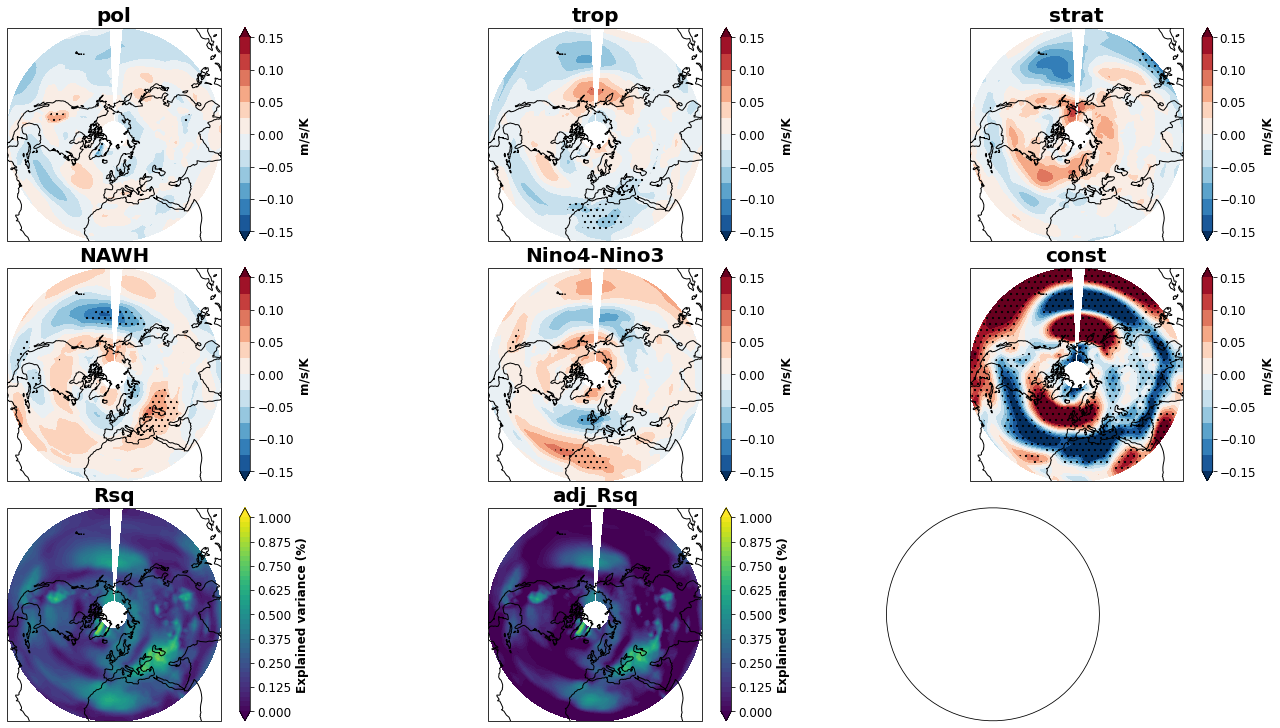

In [17]:
add_pvals = True
contour = True
data = res_ds2
fig = plt.figure(constrained_layout=True,figsize=(20,10))
axs = fig.subplots(nrows=3, ncols=3,subplot_kw={'projection': ccrs.NorthPolarStereo()}).flatten()

#labels

#color levels
colorbarMin=-0.15
colorbarMax=0.15
colorspace=0.025
clevel_coef = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=0
colorbarMax=1
colorspace=0.025
clevel_R = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

dict_cbar = {"pol": [clevel_coef,'RdBu_r','m/s/K'], "trop": [clevel_coef,'RdBu_r','m/s/K'], 
             "strat":[clevel_coef,'RdBu_r','m/s/K'],"NAWH": [clevel_coef,'RdBu_r','m/s/K'], 
             "Nino4-Nino3": [clevel_coef,'RdBu_r','m/s/K'], "const":[clevel_coef,'RdBu_r','m/s/K'],
             "Rsq":[clevel_R,'viridis','Explained variance (%)'],"adj_Rsq":[clevel_R,'viridis','Explained variance (%)']}

#hatches pvals
hatches =  ['..','']
p_levels = [0, 0.025]

for i,varname in enumerate(data.keys()):
    axi = axs[i]
    da = data[varname]
    clevs = dict_cbar[varname][0]
    color = dict_cbar[varname][1]
    label = dict_cbar[varname][2]
    
    if contour:
        h = da.plot.contourf(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False,transform=ccrs.PlateCarree())
    else:
        h = da.plot(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False,transform=ccrs.PlateCarree())
    
    #plot the colorbar:
    cbar = fig.colorbar(h, ax=axi,orientation='vertical', fraction=0.03, pad=0.05)
    cbar.ax.tick_params(labelsize=12) 
    colorLabel='[m/s]' 
    colorbarMin=-3
    cbar.set_label(label=label,fontsize=12,fontweight='bold')
    
    #pvals
    if add_pvals:
        if varname in preds+["const"]:
            da_pv = pval_ds2[varname]
            da_pv.plot.contourf(ax=axi,colors='none',levels=p_levels,hatches=hatches,extend='neither',add_colorbar=False,transform=ccrs.PlateCarree())
    
    axi.set_title(varname,fontsize=20,fontweight='bold')
    # coastlines
    axi.coastlines()
    axi.set_visible(True)
    axi.set_extent([-180, 180, 10, 90], crs=ccrs.PlateCarree())
print("Figure 1: spatial maps of the regression coefficients and explained variance when regressing the future minus past"+ 
      " change in zonal wind at 850hPa on the polar amplification (pol), the tropical warming (trop), and strospheric polar vortex"+ 
      "(strat) remote indices and the intercept (const). Stipling corresponds to region where the regression coefficients are significant at the 95% level. "+
      "The Rsq and adj_Rsq correspond to R squared and adjusted R squared respectively. To be compared with figure 2 and figure 4 from ZS2017 and OU2020 respectively.")

In [15]:
#constants
coefs = ["pol","trop","strat","NAWH","Nino4-Nino3","NAO","SCA","EA","EAWR","baro","TCWV","const"]


/!\ No field significance for: trop
/!\ No field significance for: strat
/!\ No field significance for: Nino4-Nino3


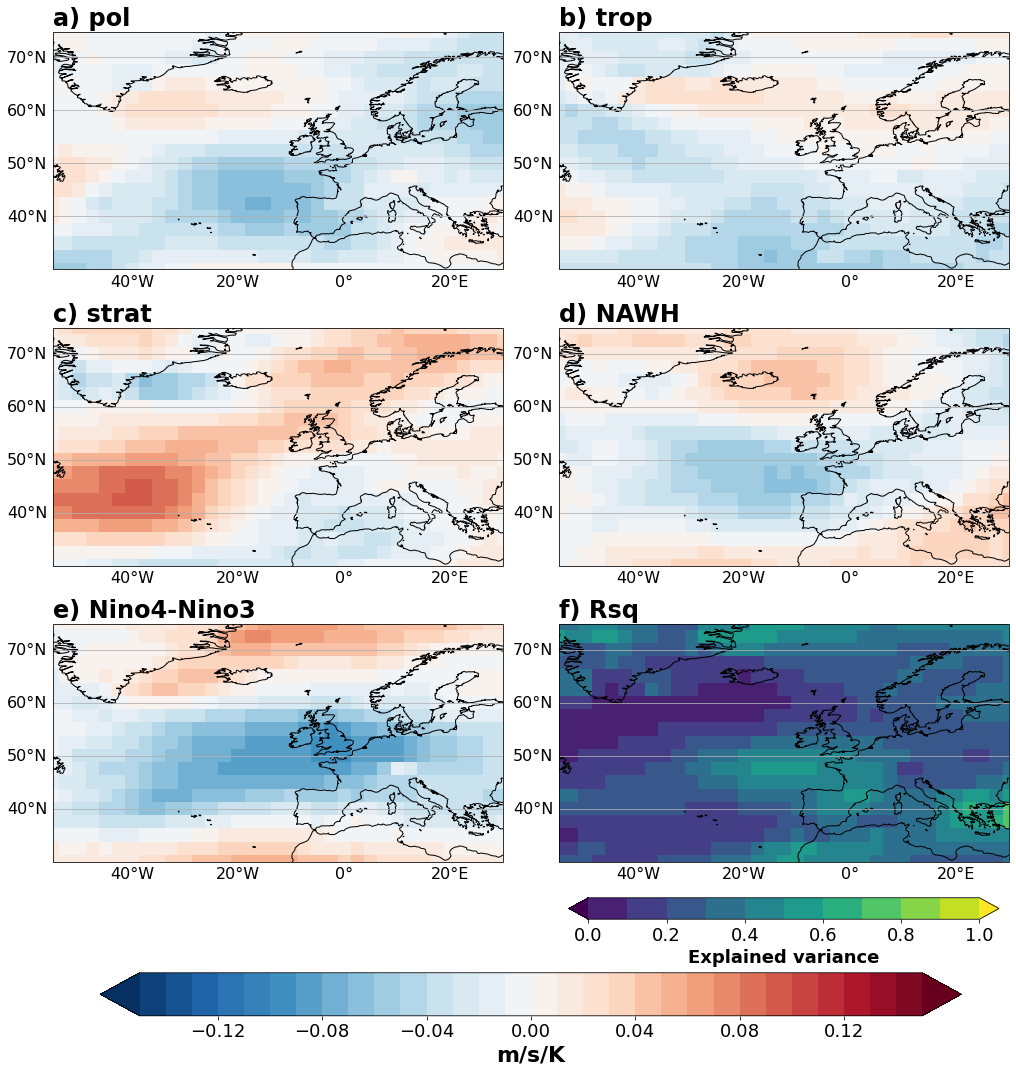

In [30]:
#select data
data = res_ds2
data_pval = pval_ds2
to_plot = data.keys()
to_plot = ["pol","trop","strat","NAWH","Nino4-Nino3","Rsq"]
labels = ["a) pol","b) trop","c) strat","d) NAWH","e) Nino4-Nino3","f) Rsq"]

nfields = len(to_plot)
add_pvals = True
field_sign = True
alpha = 0.1
alphafdr = alpha


#plotting params
saving = True
nrows = 3
extent = (-55,30,30,70)
#nrows = np.max((1,round(nfields/2)+nfields%2))
ncols = 2
#namings
savelocation="results/figures/CircScen/coefs/"
savefileName = make_fn(['mlr','OLS','U850','reg','q98','coefs']+to_plot,filetype='.png')

#color levels
colorbarMin=-0.15
colorbarMax=0.15
colorspace=0.01
clevel_coef = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=0
colorbarMax=1
colorspace=0.1
clevel_R = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

#hatches pvals
hatches =  ['..','']

#initiate plot
fig = plt.figure(constrained_layout=True,figsize=(7*ncols,5*nrows))
axs = fig.subplots(nrows=nrows, ncols=ncols,sharex=False,sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}).flatten()

hcoefs = [] #handle lists
helse = []
for i,varname in enumerate(to_plot):
    axi = axs[i]
    da = data[varname]
    label = labels[i]
    
    if varname in coefs:
        clevs = clevel_coef
        color = 'RdBu_r'
        if normresp:
            labelc = 'm/s/K'
        else:
            labelc = 'm/s'
    else:
        clevs = clevel_R
        color = 'viridis'
        labelr = 'Explained variance'
    
    #clevs = dict_cbar[varname][0]
    #color = dict_cbar[varname][1]

    h = da.plot(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False)
    
    if varname in coefs:
        hcoefs.append(h)
    else:
        helse.append(h)
        
    
    # coastlines
    axi.coastlines()
    axi.set_extent(extent)
    axi.set_visible(True)
    axi.set_title(label,fontsize=24,fontweight='bold',loc='left')
    gl = axi.gridlines(crs=ccrs.PlateCarree(), draw_labels={"bottom": "x", "left": "y"})
    gl.xlines = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}#,'weight': 'bold'
    gl.ylabel_style = {'size': 16, 'color': 'black'}#,'weight': 'bold'
    #pvals
    if add_pvals:
        if varname in preds+["const"]:
            da_pv = data_pval[varname]
            if field_sign:
                ps = da_pv.to_numpy().flatten()
                ps.sort()
                Ntests = len(ps)
                test = ps[ps<=np.arange(1,Ntests+1)*alphafdr/Ntests]
                if np.any(test):
                    pfdr = np.max(test)
                else: 
                    print("/!\ No field significance for: "+varname)
                    continue
                p_levels = [0.0, pfdr]
            else:
                p_levels = [0.0, alpha]
            
            da_pv.plot.contourf(ax=axi,colors='none',levels=p_levels,hatches=hatches,extend='neither',add_colorbar=False)
            axi.set_title(label,fontsize=24,fontweight='bold',loc='left')
        
#add colorbar
cbar_coefs = fig.colorbar(hcoefs[0], ax=axs[:-1],orientation='horizontal',extendrect=False,fraction=0.05, pad=0.1)
cbar_coefs.ax.tick_params(labelsize=18) 
cbar_rsq = fig.colorbar(helse[0], ax=axs[-1],orientation='horizontal',extendrect=False,fraction=0.08, pad=0.05)
cbar_rsq.ax.tick_params(labelsize=18) 

#label = labels[i]
cbar_coefs.set_label(label=labelc,fontsize=22,fontweight='bold')
cbar_rsq.set_label(label=labelr,fontsize=18,fontweight='bold')

#axi.set_title(varname,fontsize=20,fontweight='bold')
if saving:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

## Bootstrap regression

In [20]:
from random import sample

In [21]:
modlist = modlist_ua
sample_size = len(modlist)
sub_sample_size  = int(round(sample_size*2/3,0))

In [22]:
sample_size

28

In [23]:
# select vars
nreps = 10
reps = range(nreps)
modlist = modlist_ua
sample_size = len(modlist)
sub_sample_size  = int(round(sample_size*3/4,0))

## store vars
#resarr = np.nan * np.ones(shape=(4,4,nreps))

    
    
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict = {}
arr_dict_pval = {}
to_save = preds+["const","Rsq","adj_Rsq"]

for item in to_save:
    arr_dict[item] = xr.DataArray(np.zeros([latout.size, lonout.size,nreps]), 
                                  coords=[latout, lonout,reps], dims=['lat','lon','rep'], name=item)
for item in preds+["const"]:
    arr_dict_pval[item] = xr.DataArray(np.zeros([latout.size, lonout.size,nreps]), 
                                       coords=[latout, lonout,reps], dims=['lat','lon','rep'], name=item)

for rep in reps:
    
    start_time = timer()
    
    ##select indices and response statsmodel
    subsel = sample(modlist, k=sub_sample_size)    
    yy = resp_ds.sel(model=subsel)
    X = ind_df.loc[subsel]
    try:
        X.index = X.index.droplevel(1)
    except:
        pass
    X = X.reindex(yy.model)
    X = sm.add_constant(X) # adding a constant
    
    for ii in np.arange(0,nlat,1):
        for jj in np.arange(0,nlon,1):
            
    #         ----------------------------
            #select response variable at gridpoint
            y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
        
            #construct model
            lm = sm.OLS(y_grid_point, X) # describe model
            fit = lm.fit() # fit model
            
            #save to array
            arr_dict["Rsq"][ii,jj,rep] = fit.rsquared
            arr_dict["adj_Rsq"][ii,jj,rep] = fit.rsquared_adj
            for name,value in fit.params.items():
                arr_dict[name][ii,jj,rep] = value
                
            for name,value in fit.pvalues.items():
                arr_dict_pval[name][ii,jj,rep] = value
        
    time_delta_past = timer() - start_time
    print(time_delta_past)
            
res_ds_bs = xr.Dataset(arr_dict)
pval_ds_bs = xr.Dataset(arr_dict_pval)

KeyError: 'baro'

In [ ]:
##data to plot
#coefs
coef_qt025 = res_ds_bs[preds+["const"]].quantile(0.25,dim="rep")
coef_qt05 = res_ds_bs[preds+["const"]].quantile(0.5,dim="rep")
coef_qt975 = res_ds_bs[preds+["const"]].quantile(0.75,dim="rep")
coef_list = [coef_qt025, coef_qt05,coef_qt975]
#pvals
pvals_qt025 = pval_ds_bs[preds+["const"]].quantile(0.25,dim="rep")
pvals_qt05 = pval_ds_bs[preds+["const"]].quantile(0.5,dim="rep")
pvals_qt975 = pval_ds_bs[preds+["const"]].quantile(0.75,dim="rep")
pvals_list = [pvals_qt025, pvals_qt05,pvals_qt975]
rowlabs = ['2.5 quantile', 'median','97.5 quantile']

nrows = len(coef_list)
ncols = len(coef_qt025.data_vars)
add_pvals = False
contour = True
fig = plt.figure(constrained_layout=True,figsize=(ncols*5,nrows*4))
subfigs = fig.subfigures(nrows=nrows,ncols=1)
#axs = fig.subplots(nrows=2, ncols=4,subplot_kw={'projection': ccrs.NorthPolarStereo()})

#labels
labels = ['m/s/K', 'm/s/K' , 'm/s/K', 'm/s/K', 'Explained variance (%)', 'Explained variance (%)']

#color levels
colorbarMin=-0.15
colorbarMax=0.15
colorspace=0.025
clevel_coef = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=0
colorbarMax=1
colorspace=0.025
clevel_R = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

dict_cbar = {"pol": [clevel_coef,'RdBu_r'], "trop": [clevel_coef,'RdBu_r'], "strat":[clevel_coef,'RdBu_r'], "const":[clevel_coef,'RdBu_r'],
             "Rsq":[clevel_R,'viridis'],"adj_Rsq":[clevel_R,'viridis']}

#hatches pvals
hatches =  ['..','']
p_levels = [0, 0.025]

for irow in range(3):
    data = coef_list[irow]
    pvals = pvals_list[irow]
    subfig = subfigs[irow]
    subfig.supylabel(rowlabs[irow],fontsize=18,fontweight="bold")
    rowax = subfig.subplots(nrows=1, ncols=ncols,subplot_kw={'projection': ccrs.NorthPolarStereo()})
    #rowax = axs[irow]
    for i,varname in enumerate(data.keys()):
        axi = rowax[i]
        da = data[varname]
        clevs = dict_cbar[varname][0]
        color = dict_cbar[varname][1]
        
        if contour:
            h = da.plot.contourf(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False,transform=ccrs.PlateCarree())
        else:
            h = da.plot(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False,transform=ccrs.PlateCarree())
        
        #plot the colorbar:
        cbar = fig.colorbar(h, ax=axi,orientation='vertical', fraction=0.03, pad=0.05)
        cbar.ax.tick_params(labelsize=12) 
        colorLabel='[m/s]' 
        colorbarMin=-3
        label = labels[i]
        cbar.set_label(label=label,fontsize=12,fontweight='bold')
        
        #pvals
        if add_pvals:
            if varname in preds+["const"]:
                da_pv = pvals[varname]
                da_pv.plot.contourf(ax=axi,colors='none',levels=p_levels,hatches=hatches,extend='neither',add_colorbar=False,transform=ccrs.PlateCarree())
        
        axi.set_title(varname,fontsize=20,fontweight='bold')
        # coastlines
        axi.coastlines()
        axi.set_visible(True)
        axi.set_extent([-180, 180, 10, 90], crs=ccrs.PlateCarree())
        


## Plot fields (past, fut and diff)

In [ ]:
add_pvals = False
data = U850_ds.mean(dim="model")
fig = plt.figure(constrained_layout=True,figsize=(20,10))
axs = fig.subplots(nrows=1, ncols=3,subplot_kw={'projection': ccrs.NorthPolarStereo()}).flatten()

#labels
labels = ['m/s', 'm/s' , 'm/s/K']

#color levels
colorbarMin=-20
colorbarMax=20
colorspace=1
clevel_abs = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=-0.45
colorbarMax=0.45
colorspace=0.05
clevel_diff = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

dict_cbar = {"historical": [clevel_abs,'RdBu_r'], "ssp585": [clevel_abs,'RdBu_r'], "ssp585-historical":[clevel_diff,'RdBu_r']} 
#hatches pvals
hatches =  ['..','']
p_levels = [0.0, 0.025]

for i,varname in enumerate(data.keys()):
    axi = axs[i]
    da = data[varname]
    clevs = dict_cbar[varname][0]
    color = dict_cbar[varname][1]
    h = da.plot(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False,transform=ccrs.PlateCarree())
    
    #plot the colorbar:
    cbar = fig.colorbar(h, ax=axi,orientation='vertical', fraction=0.03, pad=0.05)
    cbar.ax.tick_params(labelsize=12) 
    colorLabel='[m/s]' 
    colorbarMin=-3
    label = labels[i]
    cbar.set_label(label=label,fontsize=12,fontweight='bold')
    
    #pvals
    if add_pvals:
        if varname in preds+["const"]:
            da_pv = pval_ds2[varname]
            da_pv.plot.contourf(ax=axi,colors='none',levels=p_levels,hatches=hatches,extend='neither',add_colorbar=False,transform=ccrs.PlateCarree())
    
    axi.set_title(varname+"\nchange in ONDJFM U850 ",fontsize=20,fontweight='bold')
    axi.set_extent([-180, 180, 10, 90], crs=ccrs.PlateCarree())
    # coastlines
    axi.coastlines()
    axi.set_visible(True)